# COVID-19 Literature search using GloVe + using K-Means and 1-D CNN trained for cluster classification to get feature represenation of Document   
**Steps:**  
**1) Load data into DataFrame.  
2) Work on a slice of DataFrame for the experiment.  
3) Clean the body text.  
4) Filter articles which are in English and remove those which are likely noise.  
5) Load the pre-trained GloVe vectors.  
6) Apply K-Means Clustering to get labels.  
7) Learn a simple 1D Convolutional Network to predict cluster.  
8) Pick the output AveragePooling Layer of 1D Convolutional Neural Network as embedding for the document.    
9) Get the norm of each document embedding and store that in a vector.  
10) Get the keywords from the question after tokenizing the question.  
11) Get the keywords embedding using AveragePooling Layer output of 1D Convolutional Neural Network.  
11) Get the norm of keywords embedding.  
12) Compute the cosine similarity using matrix vector multiplication and norms of document embeddings and keyword embeddings.  
13) Get the top 5 articles that have the highest cosine similarity with the keywords of the question.**  
  
  
*1D Convolutional Neural Networks work well for text classification. So, I have used that idea here to get document embedding using output of it's Average Pooling Layer. Output of Average Pooling layer is low dimensional feature representation of document for classifying it's cluster. Cluster will have similar document, so in that way it can act as document embedding when we are searching for a particular article.*
  


Preprocessing and loading the data taken from notebook: COVID EDA: Initial Exploration Tool, by Ivan Ega Pratama
https://www.kaggle.com/ivanegapratama/covid-eda-initial-exploration-tool

In [319]:
import numpy as np 
import pandas as pd
import glob
import json
import re
import string

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.models import Model
from keras.layers import Dense, Input, Dropout, Activation, Conv1D, GlobalAveragePooling1D, AveragePooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras import backend as K

from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from collections import Counter

Load the metadata.csv file into a DataFrame.

In [2]:
root_path = '/kaggle/input/CORD-19-research-challenge/'
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url
0,zjufx4fo,b2897e1277f56641193a6db73825f707eed3e4c9,PMC,Sequence requirements for RNA strand transfer ...,10.1093/emboj/20.24.7220,PMC125340,11742998,green-oa,Nidovirus subgenomic mRNAs contain a leader se...,2001-12-17,"Pasternak, Alexander O.; van den Born, Erwin; ...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/b2897e1277f56641193a6...,document_parses/pmc_json/PMC125340.xml.json,http://europepmc.org/articles/pmc125340?pdf=re...
1,ymceytj3,e3d0d482ebd9a8ba81c254cc433f314142e72174,PMC,"Crystal structure of murine sCEACAM1a[1,4]: a ...",10.1093/emboj/21.9.2076,PMC125375,11980704,green-oa,CEACAM1 is a member of the carcinoembryonic an...,2002-05-01,"Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/e3d0d482ebd9a8ba81c25...,document_parses/pmc_json/PMC125375.xml.json,http://europepmc.org/articles/pmc125375?pdf=re...
2,wzj2glte,00b1d99e70f779eb4ede50059db469c65e8c1469,PMC,Synthesis of a novel hepatitis C virus protein...,10.1093/emboj/20.14.3840,PMC125543,11447125,no-cc,Hepatitis C virus (HCV) is an important human ...,2001-07-16,"Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...",EMBO J,NaN,NaN,NaN,document_parses/pdf_json/00b1d99e70f779eb4ede5...,document_parses/pmc_json/PMC125543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,2sfqsfm1,cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0,PMC,Structure of coronavirus main proteinase revea...,10.1093/emboj/cdf327,PMC126080,12093723,green-oa,The key enzyme in coronavirus polyprotein proc...,2002-07-01,"Anand, Kanchan; Palm, Gottfried J.; Mesters, J...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/cf584e00f637cbd8f1bb3...,document_parses/pmc_json/PMC126080.xml.json,http://europepmc.org/articles/pmc126080?pdf=re...
4,i0zym7iq,dde02f11923815e6a16a31dd6298c46b109c5dfa,PMC,Discontinuous and non-discontinuous subgenomic...,10.1093/emboj/cdf635,PMC136939,12456663,green-oa,"Arteri-, corona-, toro- and roniviruses are ev...",2002-12-01,"van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...",The EMBO Journal,NaN,NaN,NaN,document_parses/pdf_json/dde02f11923815e6a16a3...,document_parses/pmc_json/PMC136939.xml.json,http://europepmc.org/articles/pmc136939?pdf=re...


In [3]:
meta_df.info()
#meta_df['url'][0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63571 entries, 0 to 63570
Data columns (total 18 columns):
cord_uid            63571 non-null object
sha                 48924 non-null object
source_x            63571 non-null object
title               63408 non-null object
doi                 59162 non-null object
pmcid               49732 non-null object
pubmed_id           42478 non-null object
license             63571 non-null object
abstract            51012 non-null object
publish_time        63563 non-null object
authors             60868 non-null object
journal             55602 non-null object
mag_id              970 non-null float64
who_covidence_id    1775 non-null object
arxiv_id            1166 non-null object
pdf_json_files      48924 non-null object
pmc_json_files      33503 non-null object
url                 45608 non-null object
dtypes: float64(1), object(17)
memory usage: 8.7+ MB


In [4]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

85371

Little modified helper class. It will get paper id, title, authors(concatenate first name and last name), abstract and body text from each json object.

In [5]:
class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            self.title = content['metadata']['title']
            self.authors = ''
            for author in content['metadata']['authors']:
                #concatenate first name and last name
                self.authors += author['first'] + ' ' + author['last'] + ", "
            #removing last comma and a space from string authors
            self.authors = self.authors[:-2]
            # Abstract
            try:
                for entry in content['abstract']:
                    self.abstract.append(entry['text'])
            except:
                self.abstract = []
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            #converting list to string
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
first_row = FileReader(all_json[0])
print(first_row)

PMC5730575: ... There is wide recognition of the need for the development of new antibiotics1–3. Historically, there has never been a wide selection of effective antivirals, with only antivirals for human immunodefic...


Load data(paper id, title, authors, abstract, body text) into a DataFrame after extracting data from json objects.

In [6]:
dict_ = {'paper_id': [],  'title': [], 'authors': [], 'abstract': [], 'body_text': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    content = FileReader(entry)
    dict_['paper_id'].append(content.paper_id)
    dict_['title'].append(content.title)
    dict_['authors'].append(content.authors)
    dict_['abstract'].append(content.abstract)
    dict_['body_text'].append(content.body_text)
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'title', 'authors', 'abstract', 'body_text'])
df_covid.head()

Processing index: 0 of 85371
Processing index: 8537 of 85371
Processing index: 17074 of 85371
Processing index: 25611 of 85371
Processing index: 34148 of 85371
Processing index: 42685 of 85371
Processing index: 51222 of 85371
Processing index: 59759 of 85371
Processing index: 68296 of 85371
Processing index: 76833 of 85371
Processing index: 85370 of 85371


,paper_id,title,authors,abstract,body_text
0,PMC5730575,A Simple Platform for the Rapid Development of...,"Stephen Johnston, Valeriy Domenyuk, Nidhi Gupt...",,There is wide recognition of the need for the ...
1,PMC7127289,Latent Adenovirus Infection in COPD,Shizu Hayashi,,"Several years ago, we postulated that the pers..."
2,PMC7117474,"Genetic, antigenic, and pathogenic characteris...","Zongxi Han, Wenjun Zhao, Yuqiu Chen, Qianqian ...",,"Coronaviruses (CoVs), a genus of the Coronavir..."
3,PMC2887147,Cytokine profiles of suction pulmonary secreti...,"Hisashi Kawashima, Soken Go, Yasuyo Kashiwagi,...",,Uncomplicated influenza in humans is character...
4,PMC5606103,The Clinical Significance of FilmArray Respira...,"Huanzhu Chen, Huilan Weng, Meirui Lin, Ping He...",,The community-acquired pneumonia (CAP) is the ...


Clean Duplicates.

In [7]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)

Drop null values.

In [8]:
df_covid.dropna(inplace=True)
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84543 entries, 0 to 85370
Data columns (total 5 columns):
paper_id     84543 non-null object
title        84543 non-null object
authors      84543 non-null object
abstract     84543 non-null object
body_text    84543 non-null object
dtypes: object(5)
memory usage: 3.9+ MB


Work on a small portion of DataFrame for speedup.

In [9]:
df_covid_small = df_covid.head(10000).copy()

Do some cleaning. Remove everything inside square brackets and parenthesis as these are mostly numbers and irrelevant information from body_text. Remove punctuation except for hyphen, replace \n, \t with a space, replace more than one space with single space and make everything in lower case in body_text of DataFrame df_covid_small. Keep the pre-processed body_text in new column in DataFrame called filtered_body_text.

In [10]:
df_covid_small['filtered_body_text'] = df_covid_small['body_text'].copy()

In [11]:
#remove square bracket contents
df_covid_small['filtered_body_text'] = df_covid_small['filtered_body_text'].apply(lambda x: re.sub('\[.*?\]','',x))
#remove parenthesis contents
df_covid_small['filtered_body_text'] = df_covid_small['filtered_body_text'].apply(lambda x: re.sub('\(.*?\)','',x))
#remove punctuation except hyphen
df_covid_small['filtered_body_text'] = df_covid_small['filtered_body_text'].apply(lambda x: re.sub('[^a-zA-z0-9\s-]','',x))
#remove \n \t
df_covid_small['filtered_body_text'] = df_covid_small['filtered_body_text'].apply(lambda x: re.sub('\n|\t',' ',x))
#remove extra space
df_covid_small['filtered_body_text'] = df_covid_small['filtered_body_text'].apply(lambda x: re.sub(' +',' ',x))
# make everything lower case
df_covid_small['filtered_body_text'] = df_covid_small['filtered_body_text'].apply(lambda x: x.lower())

Probably the articles which don't contain the word "the" are most likely not in English. Get rid of them. Get the indexes of the article which does not contain the word " the ".

In [12]:
ignore_idxs = []
for i in range(10000):
    if 'the' not in df_covid_small.iloc[i]['filtered_body_text']:
        ignore_idxs.append(i)

Have a look at the articles which do not contain the word "the".

In [13]:
for i in ignore_idxs[:10]:
    print (df_covid_small.iloc[i]['filtered_body_text'][:250]+"......")
    print("="*140)

la scurit sanitaire mondiale est mise au dfi par la propagation internationale des maladies les agents infectieux sont la principale source de ce dfi lhistoire est scande par des pidmies de porte mondiale ou rgionale qui furent les tmoins de ces prop......
none author yyg has no conflicts of interest pertaining to this manuscript......
la rinofaringitis es una infeccin banal y frecuente de la primera infancia cuando se presenta en su forma aguda su gravedad se debe a la presencia de complicaciones o de formas recidivantes el conocimiento de estas formas clnicas permite aplicar un t......
 dfinition pragmatique plus de trois selles trs molles ou liquides par jour depuis moins de deux semaineslapparition de selles liquides permet de porter le diagnostic de diarrhe aigu si elles sont rcentes frquentes et abondantesfacteurs de risque ass......
la displasia ectodrmica comprende un amplio y heterogneo grupo de enfermedades genticas no progresivas ocasionadas por defectos primarios en el desa

Also, remove articles whose word length is less than 500. Very likely that they are some comments and not something useful.Get the indexes and have a look at the article of word length less than 500.

In [14]:
count = 0
for i in range(10000):
    if len(df_covid_small.iloc[i]['filtered_body_text']) < 500:
        if i not in ignore_idxs:
            if count < 10:
                print(df_covid_small.iloc[i]['filtered_body_text']+"....")
                print("="*140)
            ignore_idxs.append(i)
            count += 1

the author declares that there is no conflict of interest....
after publication of the article it has been brought to our attention that an authors name has been spelt incorrectly the correct spelling should be massimo ciccozzi but it was previously included as massimo cicozzi the original version has now been revised to reflect this....
the coding-complete genome sequence of the ga99772019 isolate of the dmv1639 strain has been deposited in genbank under the accession number mk878536 raw data were deposited in the sra under accession number srr9763527 biosample number samn12347422 and bioproject number prjna556282....
the authors report no conflict of interest....
these korknu-14062014 pedv sequence data have been deposited in genbank under the accession number km403155....
the authors declare that they have no known competing financial interests or personal relationships that could have appeared to influence the work reported in this paper....
ethical approval for the study was obtai

Drop the irrelevant articles from the DataFrame.

In [15]:
df_covid_small.drop(df_covid_small.index[ignore_idxs], inplace=True)

Customize_stop_words taken from notebook: Topic Modeling: Finding Related Articles, by Daniel Wolffram:  
https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles

In [16]:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-'
]
final_stop_words = set(stopwords.words('english')).union(STOP_WORDS).union(set(customize_stop_words))

Define function tokenize_text which takes body_text of article and return tokens as string after removing stop words and lemmatizing

In [17]:
def tokenize_text(text):
    tokens = nltk.word_tokenize(text)
    #remove stop words
    tokens = list(filter(lambda x: x not in final_stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    return ' '.join(list(tokens))

Add a new column in dataframe tokenized_text which will store the tokens as string of body_text of article.

In [18]:
df_covid_small["tokenized_text"] = df_covid_small["filtered_body_text"].apply(tokenize_text)

Use K-means clustering to add labels to the dataset.  
K-means clustering code from notebook, "COVID-19 Literature Clustering" by MaksimEkin, SoloNick    

Define function vectorize which vectorizes text using tf-idf vectorizer.  
We will be clustering based off the content of the body text. The maximum number of features will be limited. Only the top 2 ** 12 features will be used, eseentially acting as a noise filter. Additionally, more features cause painfully long runtimes.  

Apply PCA to reduce the dimensions while still keeping 95% variance. 

To separate the literature, k-means will be run on the vectorized text. 

Using elbow method value of best k was 20  
Refernce: https://www.kaggle.com/maksimeren/covid-19-literature-clustering

In [19]:
def vectorize(text, maxx_features):    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [20]:
text = df_covid_small['tokenized_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(9780, 4096)

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(9780, 2110)

In [23]:

k = 20
kmeans = KMeans(n_clusters=k, random_state=0)
y_pred = kmeans.fit_predict(X_reduced)
df_covid_small['y'] = y_pred

Split dataframe in three parts

In [24]:
X_train = df_covid_small.iloc[:5000]["tokenized_text"]
Y_train = df_covid_small.iloc[:5000]['y']
X_val = df_covid_small.iloc[5000:7000]["tokenized_text"]
Y_val = df_covid_small.iloc[5000:7000]['y']
X_test = df_covid_small.iloc[7000:9000]["tokenized_text"]
Y_test = df_covid_small.iloc[7000:9000]['y']

Find average word count in an article.

In [25]:
corpus_word_count, avg_corpus_word_count = 0, 0
for i in range(X_reduced.shape[0]):
    corpus_word_count += len(df_covid_small.iloc[i]['tokenized_text'].split(" "))
avg_corpus_word_count = corpus_word_count / X_reduced.shape[0]
print (avg_corpus_word_count)

2232.802351738241


Load the pre-trained GloVe (Global Vectors for Word Representation) word vectors. It has 6B tokens, 400K vocab, (50d, 100d, 200d, & 300d vectors). Load the 50d version for now.
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014 https://nlp.stanford.edu/projects/glove/  
  
Define a function read_glove_vecs which takes a file containing pre-trained GloVe word vectors and returns dictionaries:  
words_to_index: given a word, get it's index(just an integer)  
index_to_words: given index, get corresponding word  
word_to_vec_map: given a word, get its word embedding vector  

Code from coursera course on sequence models by deeplearning.ai taught by Andrew Ng: https://www.coursera.org/learn/nlp-sequence-models

In [26]:
#From coursera course on sequence models
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map
root_path = '/kaggle/input/glove6b50d'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(f'{root_path}/glove.6B.50d.txt')

Following functions are from my assignment from coursera course on Sequence Models:  
convert_to_one_hot: takes categorical variable Y and number of categories and convert it to one hot encoding  
  
sentences_to_indices: Converts an array of documents (here article/papers) into an array of indices corresponding to words in the documents. max_len is maximum number of words article can have. Average number of words is around 2200, so let's take 1500 words from article.  

pretrained_embedding_layer: Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors. The embedding layer takes as input a list of word indices. sentences_to_indices() creates these word indices. The embedding layer will return the word embeddings for a document.  




In [27]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.values.reshape(-1)]
    return Y

In [28]:
def sentences_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   
    X_indices = np.zeros((m,max_len))
    for i in range(m):                          
        sentence_words = X.iloc[i].split()
        j = 0
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                j = j + 1
            if j == 1500:
                break
            
    return X_indices

In [29]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1                 
    emb_dim = word_to_vec_map["cucumber"].shape[0]  
    
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(input_dim=vocab_len, output_dim=emb_dim, trainable=False)
 
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

Build train, test, validation data

In [243]:
X_train_indices = sentences_to_indices(X_train, words_to_index, 1500)
Y_train_oh = convert_to_one_hot(Y_train, C = 20)
X_test_indices = sentences_to_indices(X_test, words_to_index, 1500)
Y_test_oh = convert_to_one_hot(Y_test, C = 20)
X_val_indices = sentences_to_indices(X_val, words_to_index, 1500)
Y_val_oh = convert_to_one_hot(Y_val, C = 20)

Build 1D Convolutional Neural Network for classifying documents into clusters with following structure:  
Embedding Layer loaded with pre-trained GloVe vectors  
Dropout of 20%
1D Convolution Layer with best_n_filters, best_filter_size  
Global Averaging Layer  
Fully Connected Layer with 100 units  
Fully Connected Layer with 20 units
Softmax Layer

Use Validation Set to get best number of filters and filter size.  
Output of next cell is hidden for readability.

In [ ]:
def cnn(input_shape, word_to_vec_map, word_to_index,n_filters,filter_size):
    sentence_indices = Input(shape=input_shape, dtype='int32')
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    embeddings = embedding_layer(sentence_indices)
    X = Dropout(rate=0.2)(embeddings)
    X = Conv1D(filters=n_filters,kernel_size=filter_size,activation='relu')(X)
    X = GlobalAveragePooling1D()(X)
    X = Dense(units=100)(X)
    X = Dropout(rate=0.4)(X)
    X = Activation('relu')(X)
    X = Dense(units=20)(X)
    X = Activation('softmax')(X)
    model = Model(inputs=sentence_indices, outputs=X) 
    return model

n_filters_list, filter_size_list = [64,128,256,512,1024], [3,5,10,15,20]
best_acc = 0
best_n_filters, best_filter_size = 0, 0
for n_filters in n_filters_list:
    print(n_filters)
    for filter_size in filter_size_list:
        model = cnn((1500,), word_to_vec_map, words_to_index, n_filters, filter_size)
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train_indices, Y_train_oh, epochs = 30, batch_size = 32, shuffle=True)
        loss, acc = model.evaluate(X_val_indices, Y_val_oh)
        if acc > best_acc:
            best_acc = acc
            best_n_filters = n_filters
            best_filter_size = filter_size

In [281]:
print(best_n_filters, best_filter_size)

512 5


Train the model using best filter size and best number of filters.

In [282]:
model = cnn((1500,), word_to_vec_map, words_to_index, best_n_filters, best_filter_size)
model.summary()

Model: "model_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_88 (InputLayer)        (None, 1500)              0         
_________________________________________________________________
embedding_88 (Embedding)     (None, 1500, 50)          20000050  
_________________________________________________________________
dropout_79 (Dropout)         (None, 1500, 50)          0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 1496, 512)         128512    
_________________________________________________________________
global_average_pooling1d_83  (None, 512)               0         
_________________________________________________________________
dense_120 (Dense)            (None, 100)               51300     
_________________________________________________________________
dropout_80 (Dropout)         (None, 100)               0  

In [283]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_indices, Y_train_oh, epochs = 300, batch_size = 32, shuffle=True)

Epoch 1/300
5000/5000 [==============================] - 2s 409us/step - loss: 2.1977 - accuracy: 0.3434
Epoch 2/300
5000/5000 [==============================] - 2s 361us/step - loss: 1.7402 - accuracy: 0.4802
Epoch 3/300
5000/5000 [==============================] - 2s 381us/step - loss: 1.5863 - accuracy: 0.5190
Epoch 4/300
5000/5000 [==============================] - 2s 365us/step - loss: 1.4964 - accuracy: 0.5440
Epoch 5/300
5000/5000 [==============================] - 2s 355us/step - loss: 1.4531 - accuracy: 0.5492
Epoch 6/300
5000/5000 [==============================] - 2s 355us/step - loss: 1.3865 - accuracy: 0.5644
Epoch 7/300
5000/5000 [==============================] - 2s 355us/step - loss: 1.3593 - accuracy: 0.5736
Epoch 8/300
5000/5000 [==============================] - 2s 352us/step - loss: 1.3297 - accuracy: 0.5884
Epoch 9/300
5000/5000 [==============================] - 2s 358us/step - loss: 1.2852 - accuracy: 0.5918
Epoch 10/300
5000/5000 [==============================]

5000/5000 [==============================] - 2s 355us/step - loss: 0.4125 - accuracy: 0.8508
Epoch 155/300
5000/5000 [==============================] - 2s 354us/step - loss: 0.4060 - accuracy: 0.8474
Epoch 156/300
5000/5000 [==============================] - 2s 367us/step - loss: 0.4077 - accuracy: 0.8540
Epoch 157/300
5000/5000 [==============================] - 2s 357us/step - loss: 0.3844 - accuracy: 0.8638
Epoch 158/300
5000/5000 [==============================] - 2s 352us/step - loss: 0.3937 - accuracy: 0.8580
Epoch 159/300
5000/5000 [==============================] - 2s 355us/step - loss: 0.3893 - accuracy: 0.8564
Epoch 160/300
5000/5000 [==============================] - 2s 353us/step - loss: 0.3997 - accuracy: 0.8594
Epoch 161/300
5000/5000 [==============================] - 2s 371us/step - loss: 0.3746 - accuracy: 0.8740
Epoch 162/300
5000/5000 [==============================] - 2s 367us/step - loss: 0.4013 - accuracy: 0.8534
Epoch 163/300
5000/5000 [==========================

In [284]:
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print("Test accuracy = ", acc)

2000/2000 [==============================] - 0s 200us/step
Test accuracy =  0.7394999861717224


Test accuracy of around 74% for 20 class classification is a good baseline model. It can be further improved though.

Build X matrix containing word indices for each documents.

In [299]:
X = df_covid_small["tokenized_text"]
X = sentences_to_indices(X, words_to_index, 1500)

Define function to get output of average pooling layer

In [329]:
get_avg_pool_layer_output = K.function([model.layers[0].input], [model.layers[4].output])

Create a matrix, doc_embeddings which will store the embedding vector for each document in df_covid_small DataFrame.  
Create a column vector, norms_doc_embeddings which will store the norm of embedding vector for each document in df_covid_small DataFrame.  

In [406]:
doc_embeddings = np.zeros((X.shape[0],512))
norms_doc_embeddings = np.zeros((X.shape[0],1))

Build the doc_embeddings matrix row by row by passing each document through CNN and getting the corresponding output of Average Pooling Layer as it's document embedding vector. Get the norm of each document embedding vector and store it in a column vector norm_doc_embeddings.

In [411]:
for i in range(X.shape[0]):
    if i % 1000 == 0:
        print("working on "+str(i)+"th document")
    doc_embedding_vec = np.array(get_avg_pool_layer_output(X[i].reshape(1,-1))).reshape(1,-1)
    norms_doc_embeddings[i,:] = np.sqrt(np.dot(doc_embedding_vec,doc_embedding_vec.T))
    doc_embeddings[i,:] = doc_embedding_vec

working on 0th document
working on 1000th document
working on 2000th document
working on 3000th document
working on 4000th document
working on 5000th document
working on 6000th document
working on 7000th document
working on 8000th document
working on 9000th document


Define a function get_kw_from_question which will return keywords(filtered tokens) from a question.

In [412]:
def get_kw_from_question(question):
    question = question.lower()
    #remove hyphen from string.punctuation and remove all other punctuation
    question = question.translate(str.maketrans('', '', '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'))
    tokens = nltk.word_tokenize(question)
    #remove stop words
    tokens = list(filter(lambda x: x not in final_stop_words, tokens))
    #lemmatize the words so that other forms of same word becomes a single word
    tokens = list(map(lambda x: nltk.WordNetLemmatizer().lemmatize(x), tokens))
    #return words which have frequency greater than 1
    return ' '.join(list(tokens))

Let's ask a question and get it's keywords. Since if length of document is less than 1500, we append 0s. So to avoid too many 0s, I am making the question 10 times its length by appending it 10 times.

In [665]:
question = "What is the evidence that livestock could be infected (field surveillance, genetic sequencing, receptor binding)? \
Evidence of whether farmers are infected, and whether farmers could have played a role in the origin. "
question = question*10
keywords = get_kw_from_question(question)
keywords

'evidence livestock infected field surveillance genetic sequencing receptor binding evidence farmer infected farmer played role origin evidence livestock infected field surveillance genetic sequencing receptor binding evidence farmer infected farmer played role origin evidence livestock infected field surveillance genetic sequencing receptor binding evidence farmer infected farmer played role origin evidence livestock infected field surveillance genetic sequencing receptor binding evidence farmer infected farmer played role origin evidence livestock infected field surveillance genetic sequencing receptor binding evidence farmer infected farmer played role origin evidence livestock infected field surveillance genetic sequencing receptor binding evidence farmer infected farmer played role origin evidence livestock infected field surveillance genetic sequencing receptor binding evidence farmer infected farmer played role origin evidence livestock infected field surveillance genetic sequen

Get the embedding vector for the keywords of the question by passing those to CNN and getting output of average pooling layer. Calculate it's norm for calculating cosine similarity.

In [666]:
kw_embedding_vec = np.array(get_avg_pool_layer_output(sentences_to_indices(pd.Series(keywords), words_to_index, 1500))).reshape(1,-1)
norm_kw_embedding = np.sqrt(np.dot(kw_embedding_vec, kw_embedding_vec.T))

# Cosine similarity
(taken from coursera course on sequence models by deeplearning.ai taught by Andrew Ng: https://www.coursera.org/learn/nlp-sequence-models)  
To measure the similarity between two words, we need a way to measure the degree of similarity between two embedding vectors for the two words. Given two vectors $u$ and $v$, cosine similarity is defined as follows: 

$$\text{CosineSimilarity(u, v)} = \frac {u \cdot v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$
* $u \cdot v$ is the dot product (or inner product) of two vectors
* $||u||_2$ is the norm (or length) of the vector $u$
* $\theta$ is the angle between $u$ and $v$. 
* The cosine similarity depends on the angle between $u$ and $v$. 
    * If $u$ and $v$ are very similar, their cosine similarity will be close to 1.
    * If they are dissimilar, the cosine similarity will take a smaller value.

Get the product of norms for computing cosine similarity. norm_prods vector will contain the product of norms of each document embedding vector and keyword embedding vector.

In [667]:
norm_prods = norms_doc_embeddings * norm_kw_embedding

Compute the matrix vector multiplication of doc_embeddings and kw_embedding_vec. Result will be vector which will act as numerator when computing the cosine similarity.

In [668]:
dot_prod = np.dot(doc_embeddings, kw_embedding_vec.T)

Now, vector dot_prod contains the numerator for cosine similarity between each document embedding vector and keyword embedding vector. To compute the cosine similarity between each document embedding vector and keyword embedding vector, divide the dot_prod vector by norms_prod vector(which contains the product of norms of each document embedding vector and keyword embedding vector).

In [669]:
cosine_similarity = dot_prod / norm_prods

Visualize the cosine similarities of the first 100 articles with the keywords of the question.

Text(0, 0.5, 'cosine similarity with question keywords')

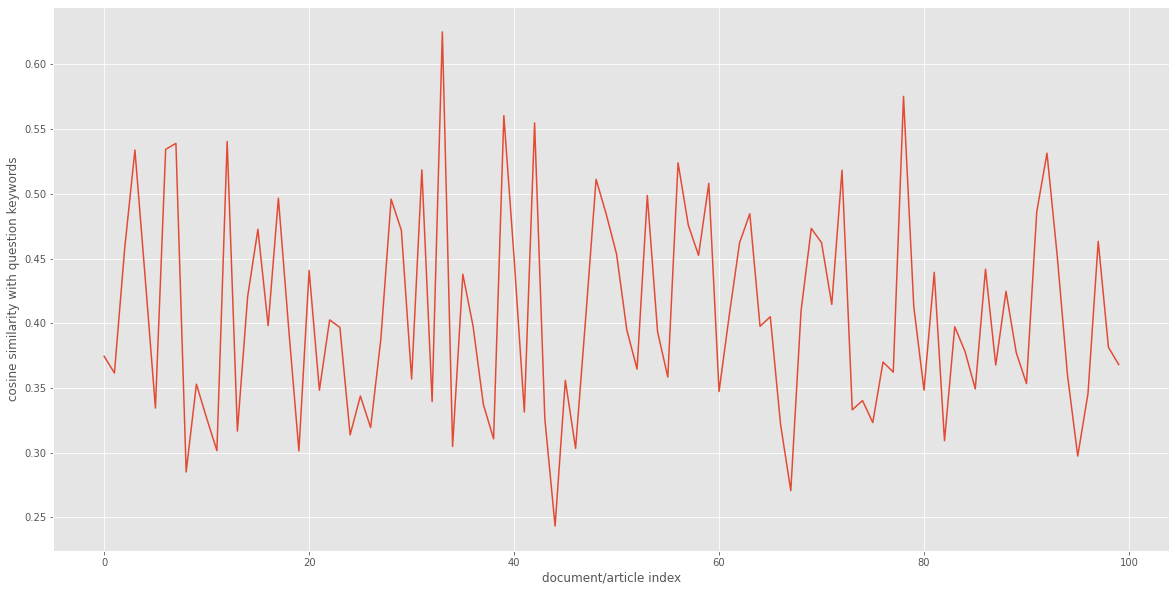

In [670]:
fig = plt.figure(figsize=(20,10))
plt.plot(cosine_similarity[:100])
plt.xlabel('document/article index')
plt.ylabel('cosine similarity with question keywords')

Make the cosine_similarity array as 1-Dimensional. It will be needed for argpartition later.

In [671]:
cosine_similarity = cosine_similarity.reshape(-1,)

Now, to get the indexes corresponding highest cosine similarity. Say the top 5 articles/documents which have the highest cosine similarity between keywords we want. Since sorting the entire array is not needed so better to use argpartition instead of argsort. Unlike argsort, this function runs in linear time in the worst case.  
Taken from: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array

In [672]:
reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]

In [673]:
cosine_similarity[reqd_idxs]

array([0.65206499, 0.65532558, 0.65749678, 0.65664156, 0.66180562])

Returned indices from argpartition are not sorted. Sort them and reverse the array. Now reqd_idxs contains indexes of top 5 articles/documents sorted according to highest cosine similarity with the keyword.

In [674]:
reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
reqd_idxs

array([7087, 1248, 4639, 9741, 2615])

In [675]:
print("Articles for your question: ")
for idx in reqd_idxs:
    print(df_covid_small.iloc[idx]['title']+" by "+ df_covid_small.iloc[idx]['authors'])
    print(df_covid_small.iloc[idx]['body_text'][:1000]+"......")
    print()

Articles for your question: 
Canine infectious respiratory disease: Tackling the unknown unknowns by S.L. Priestnall, K.C. Smith
When the then US Secretary of Defence Donald Rumsfeld made his famous and rather unjustly mocked 2002 NATO speech about the ‘known knowns, known unknowns and unknown unknowns’ in matters of national security
1 he hit on an important truth about veterinary research, namely, it is only in hindsight that we realise how long we have not known something about animal disease. That truth is illustrated by the article by Dr. Tara Anderson of the University of Florida and her colleagues published in this issue of The Veterinary Journal (Anderson et al., 2012). The study describes how retrospective serological analysis demonstrates that host-adapted H3N8 canine influenza was circulating in greyhounds in North America at least as early as 1999. This is an important observation as previous understanding was that this novel disease first occurred in the USA in 2004, since

So, now let's make a function for doing all these things i.e. calculating cosine similarity and getting the indexes of top 5 articles which have the highest cosine similarity with the keywords of the question.

In [676]:
def compute_cosine_get_idxs(keywords, norms_doc_embeddings, doc_embeddings):
    kw_embedding_vec = np.array(get_avg_pool_layer_output(sentences_to_indices(pd.Series(keywords), words_to_index, 1500))).reshape(1,-1)
    norm_kw_embedding = np.sqrt(np.dot(kw_embedding_vec, kw_embedding_vec.T))
    norm_prods = norms_doc_embeddings * norm_kw_embedding
    dot_prod = np.dot(doc_embeddings, kw_embedding_vec.T)
    cosine_similarity = dot_prod / norm_prods
    cosine_similarity = cosine_similarity.reshape(-1,)
    reqd_idxs = np.argpartition(cosine_similarity, -5)[-5:]
    reqd_idxs = reqd_idxs[np.argsort(cosine_similarity[reqd_idxs])][::-1]
    return reqd_idxs  

In [677]:
question = "What are the sustainable risk reduction strategies? "
question = question*10
keywords = get_kw_from_question(question)
reqd_idxs = compute_cosine_get_idxs(keywords, norms_doc_embeddings, doc_embeddings)
print("Articles for your question: ")
for idx in reqd_idxs:
    print(df_covid_small.iloc[idx]['title']+" by "+ df_covid_small.iloc[idx]['authors'])
    print(df_covid_small.iloc[idx]['body_text'][:1000]+"......")
    print()

Articles for your question: 
Editorial overview: Preventive and therapeutic vaccines: Vaccination against viral disease — current advances and challenges by Rino Rappuoli, Gerd Sutter
Vaccines are probably the most efficacious public health tools of the 20th Century having greatly reduced both morbidity and mortality from viral diseases across the globe. Today, vaccination against viral disease moves to confront the challenges of emerging infections that are caused by pathogens with little known biology and associated with unpredictable impact on our societies. Moreover, the field still needs to address the massive disease burden from chronic infections caused by viruses that already know the tricks to efficiently evade the human immune system. New insights into the immune correlates of protection from viral diseases and into the vaccine prerequisites for the rational induction of safe and broadly protective immune responses offer promising chances for highly innovative vaccine develop

In [678]:
question = "What do we know about virus genetics, origin, and evolution? What do we know about Real-time tracking of whole genomes "
question = question*10
keywords = get_kw_from_question(question)
reqd_idxs = compute_cosine_get_idxs(keywords, norms_doc_embeddings, doc_embeddings)
print("Articles for your question: ")
for idx in reqd_idxs:
    print(df_covid_small.iloc[idx]['title']+" by "+ df_covid_small.iloc[idx]['authors'])
    print(df_covid_small.iloc[idx]['body_text'][:1000]+"......")
    print()

Articles for your question: 
Sequencing the whole genome of infected human cells obtained from diseased patients – a proposed strategy for understanding and overcoming AIDS or other deadest virus-infected diseases by Da-Yong Lu, Jian Ding
To the etiology of virus-infected diseases, the farthest and worst outcomes will be in the changes of cellular genome. If these deadest virus or their influences really enter or devour into human genomes of infected cells in nature, we will not surprise why routine vaccines and exogenous chemical drugs could not eradicate the diseases after so many laboratory endeavors and high expenses of money. Therefore, we propose that final solution and eradication of these deadest diseases will only be based on thorough understanding the courses and ranges of virus infections. Since human genome project (HGP) has been just finished and has great potential in medicine [5], is it better to sequence the whole genome of infected human cells obtained from diseased pa

In [679]:
question = "What about Animal host and any evidence of continued spill over to humans, Socioeconomic and behavioral risk factors for this spill over? "
question = question*10
keywords = get_kw_from_question(question)
reqd_idxs = compute_cosine_get_idxs(keywords, norms_doc_embeddings, doc_embeddings)
print("Articles for your question: ")
for idx in reqd_idxs:
    print(df_covid_small.iloc[idx]['title']+" by "+ df_covid_small.iloc[idx]['authors'])
    print(df_covid_small.iloc[idx]['body_text'][:1000]+"......")
    print()

Articles for your question: 
The interface of animal and human vaccines by Connie Schmaljohn, Christian Mandl
Viral zoonoses are an important cause of human morbidity and mortality. As more information has accumulated, it has become obvious that animal health and human health cannot be separated. Animals not only function to maintain and amplify pathogenic viruses in nature, but cross-species transmission can occur for members of numerous viral families and such events have in the past, and likely will continue in the future, to give rise to new veterinary or human disease agents. Vaccination of wildlife or domesticated animals can be effective for preventing some viral diseases of humans, but not all. Vector or host control measures are often also required, and for certain viruses, it is simply not feasible to vaccinate the wide variety of hosts that harbor them in nature. Likewise, eradication of zoonotic viruses through vaccination, while a worthy goal, will be possible for only a f